## Import libraries

In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Read data

In [85]:
y_a = pd.read_parquet('A/train_targets.parquet')
y_b = pd.read_parquet('B/train_targets.parquet')
y_c = pd.read_parquet('C/train_targets.parquet')

X_a = pd.read_parquet('A/X_train_observed.parquet')
X_b = pd.read_parquet('B/X_train_observed.parquet')
X_c = pd.read_parquet('C/X_train_observed.parquet')

X_a_estimated = pd.read_parquet('A/X_train_estimated.parquet')
X_b_estimated = pd.read_parquet('B/X_train_estimated.parquet')
X_c_estimated = pd.read_parquet('C/X_train_estimated.parquet')

X_a_test = pd.read_parquet('A/X_test_estimated.parquet')
X_b_test = pd.read_parquet('B/X_test_estimated.parquet')
X_c_test = pd.read_parquet('C/X_test_estimated.parquet')

## Concat data

In [86]:
X = pd.concat([X_a, X_b, X_c, X_a_estimated, X_b_estimated, X_c_estimated])

## Fix snow density feature

**snow_density:kgm3** has a lot of NaN values and we have to fix this

In [87]:
X["snow_density:kgm3"] = X["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})

## Define helper functions

In [88]:
def drop_cols(to_drop):
    X_a.drop(to_drop, axis=1, inplace=True)
    X_b.drop(to_drop, axis=1, inplace=True)
    X_c.drop(to_drop, axis=1, inplace=True)
    X_a_estimated.drop(to_drop, axis=1, inplace=True)
    X_b_estimated.drop(to_drop, axis=1, inplace=True)
    X_c_estimated.drop(to_drop, axis=1, inplace=True)

def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def show_corr_matrix_with_values(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

## Data cleaning - Correlations

Let's first have a look at the correlation matrix:

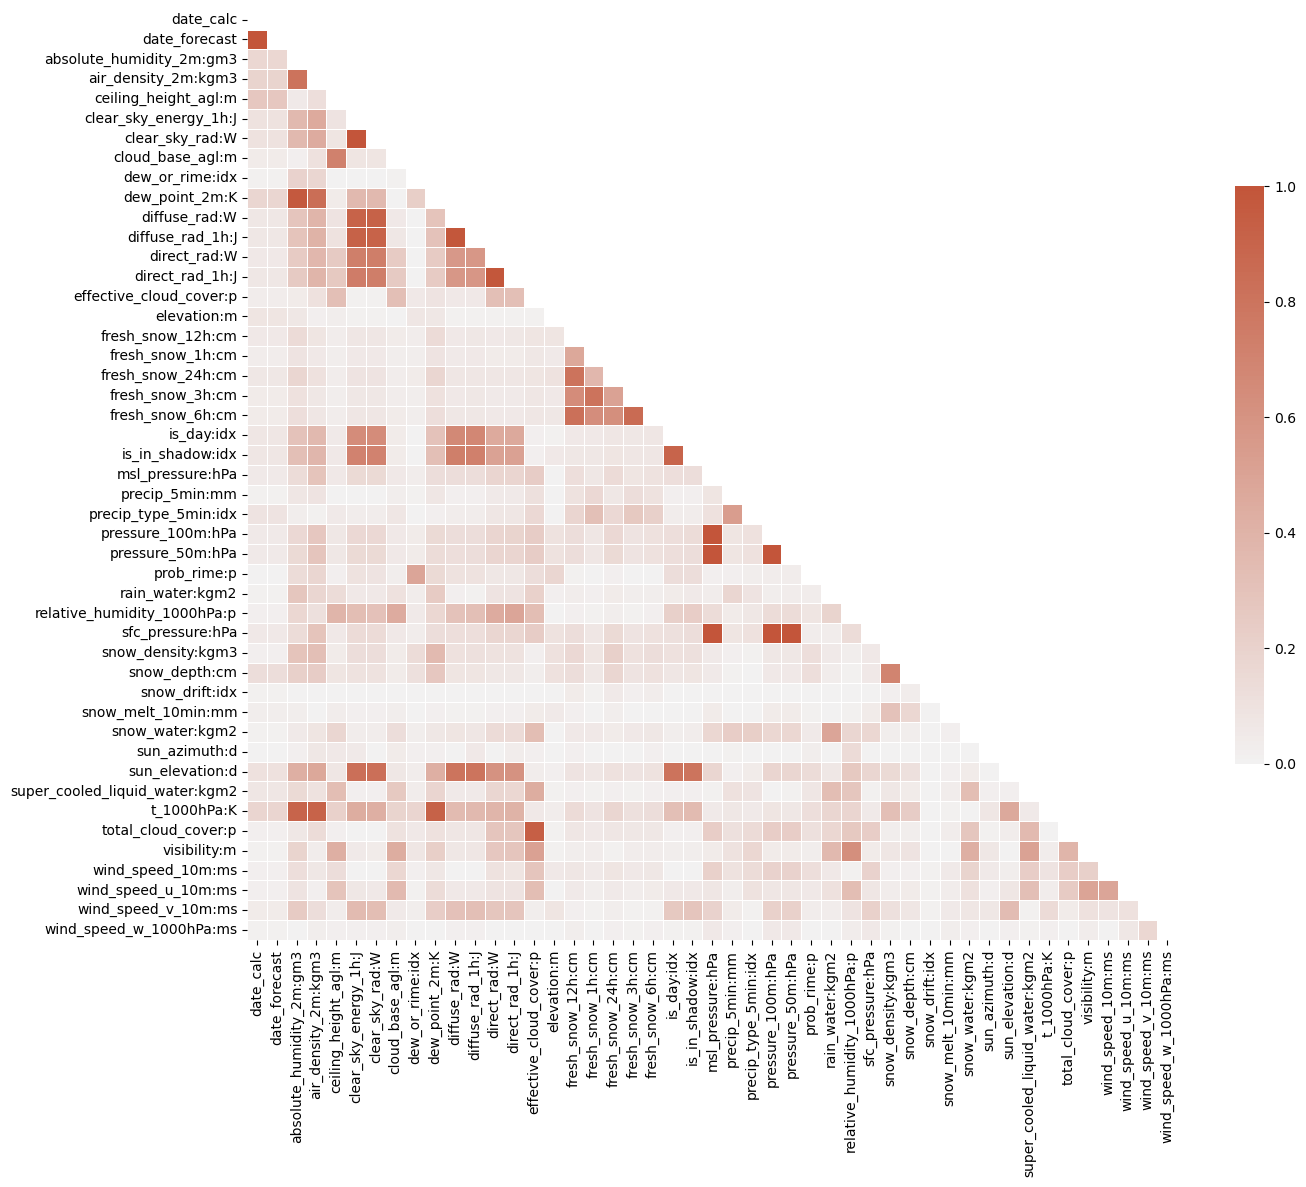

In [89]:
show_corr_matrix(X)

## Snow

I'll first remove some of the features that are double up. Specifically let's get rid of some of the **snow-features**:

In [90]:
to_drop = ['fresh_snow_12h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

X.drop(to_drop, axis=1, inplace=True)

Now let's look at the correlation matrix again

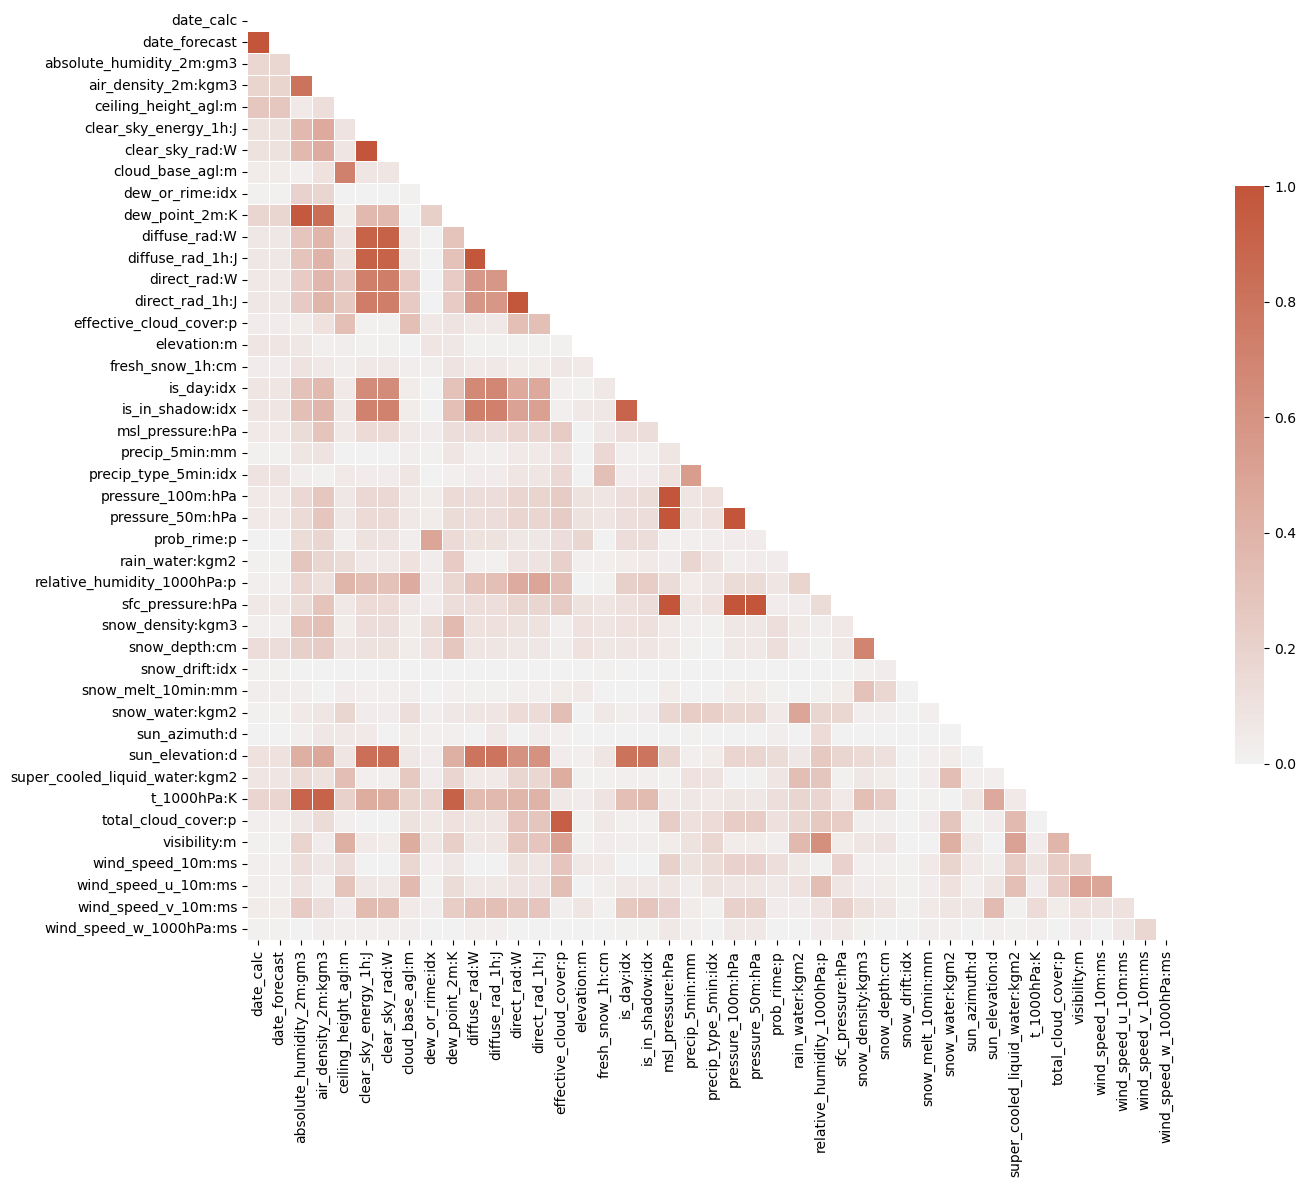

In [91]:
show_corr_matrix(X)

## Accumulative features

Now let's also remove the attributes that has a 1h accumulative option:

In [92]:
to_drop = ['diffuse_rad:W', 'direct_rad:W']

X.drop(to_drop, axis=1, inplace=True)

Another look at the corr_matrix:

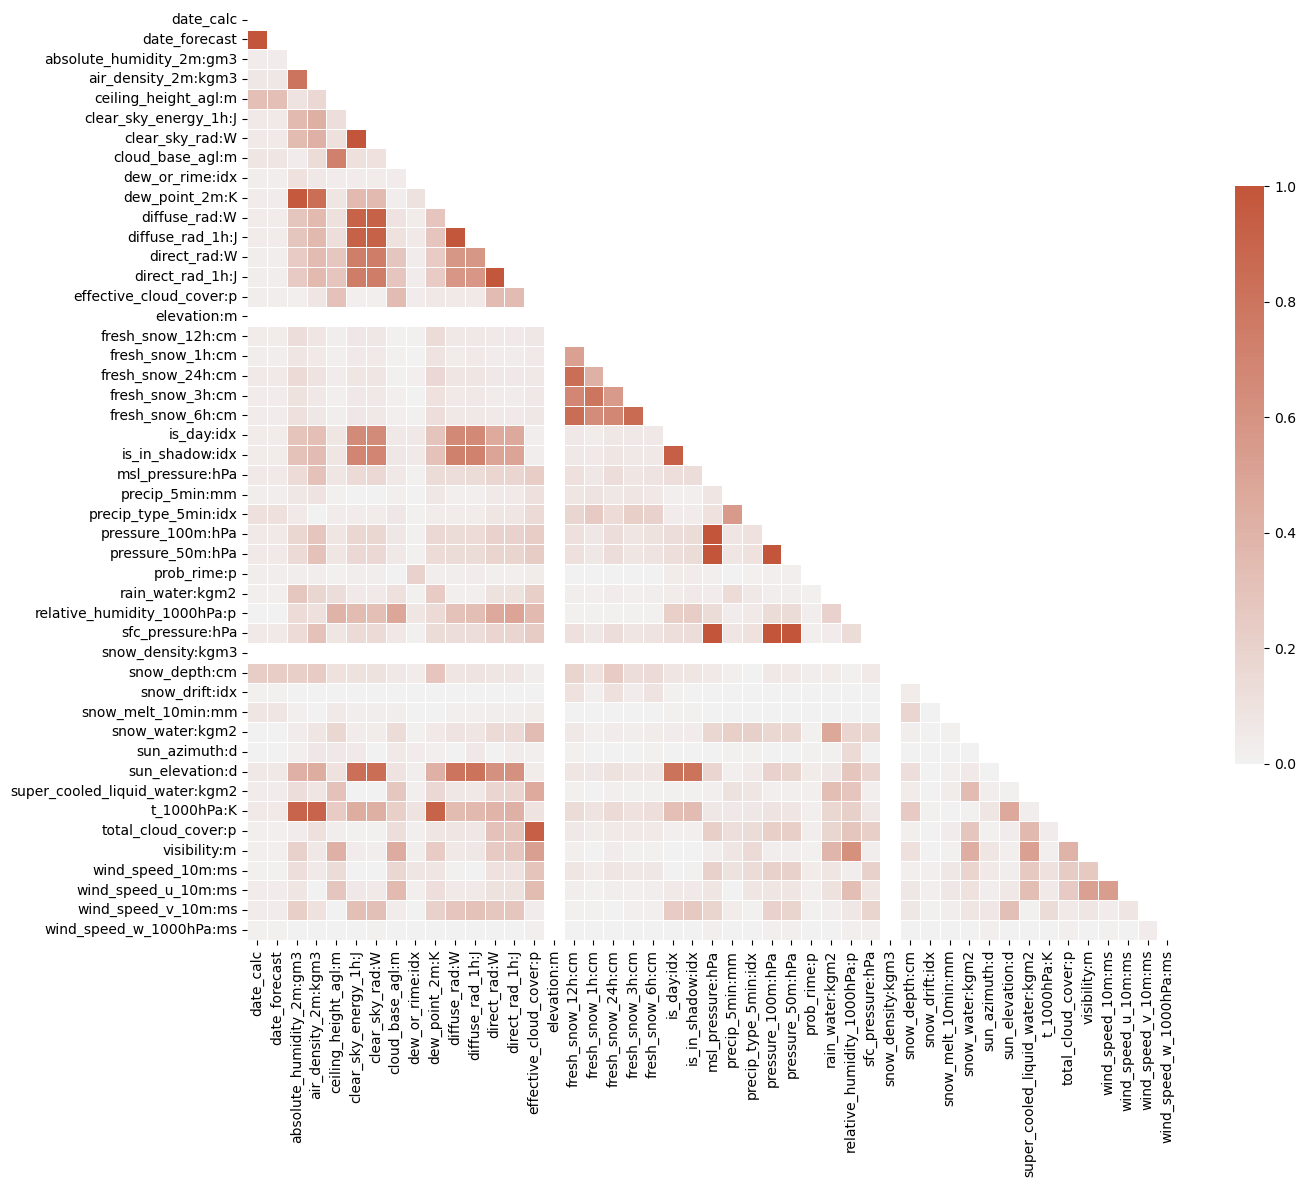

In [93]:
show_corr_matrix(X_b)

## Pressure

Let's now have a look at the pressure features:

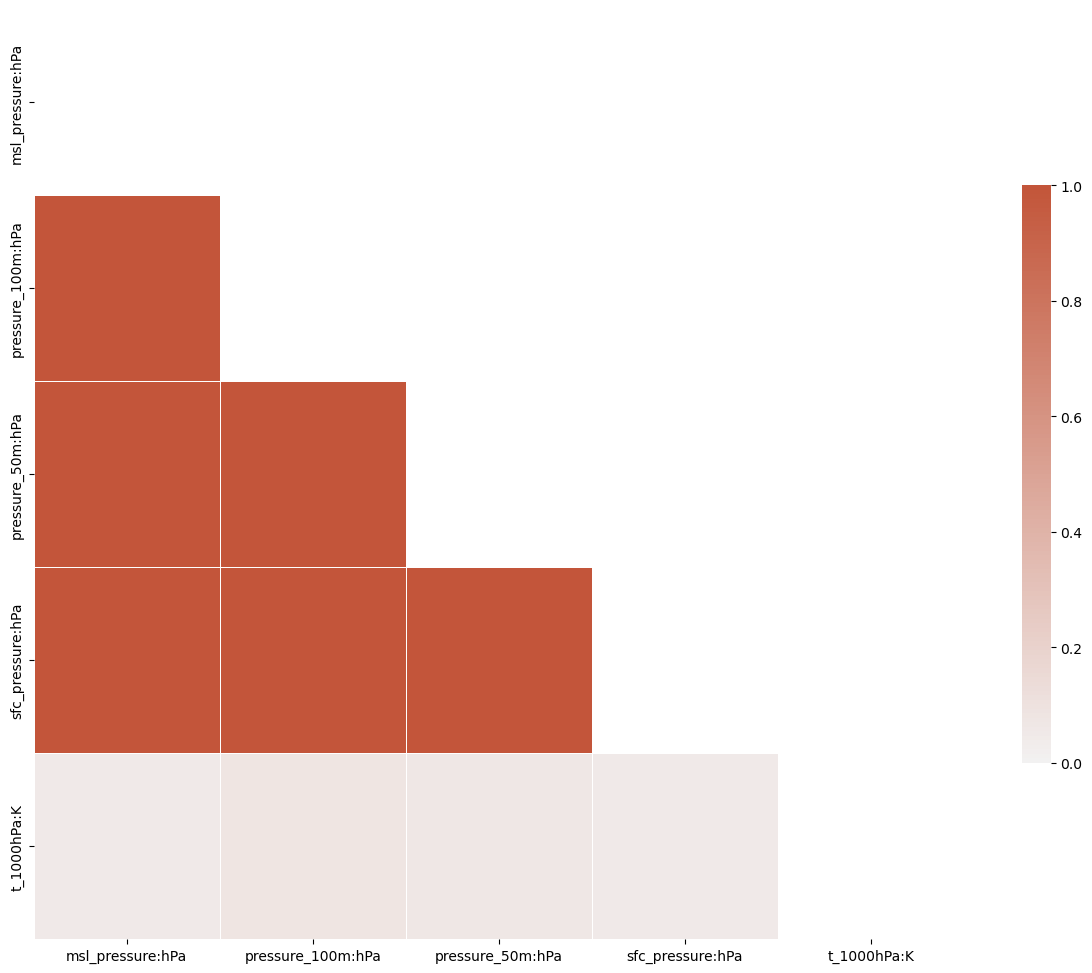

In [94]:
pressure_features = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa', 't_1000hPa:K']

show_corr_matrix(X[pressure_features])

It's apparent that 'pressure_100m:hPa', 'pressure_50m:hPa' and 'sfc_pressure:hPa' have a very high correlation. Let's look closer into what kind of information they give us:

**pressure_000m:hPa**: atmospheric pressure, available up to 20 km altitude [hPa]

**sfc_pressure:hPa**: surface pressure [hPa]

**msl_pressure:hPa**: mean sea level pressure [hPa]

**t_000m:C**: instantaneous temperature at the indicated level above ground in the corresponding unit [K]

So the last one is a temperature reading at a level above ground corresponding to 1000hPa of pressure. According to google that is the usual pressure at **sea level**

After some back and forth with chatGPT it seems that of the different altitudes, the best was to keep the mean sea level-pressure.

In [95]:
to_drop = ['pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']

X.drop(to_drop, axis=1, inplace=True)

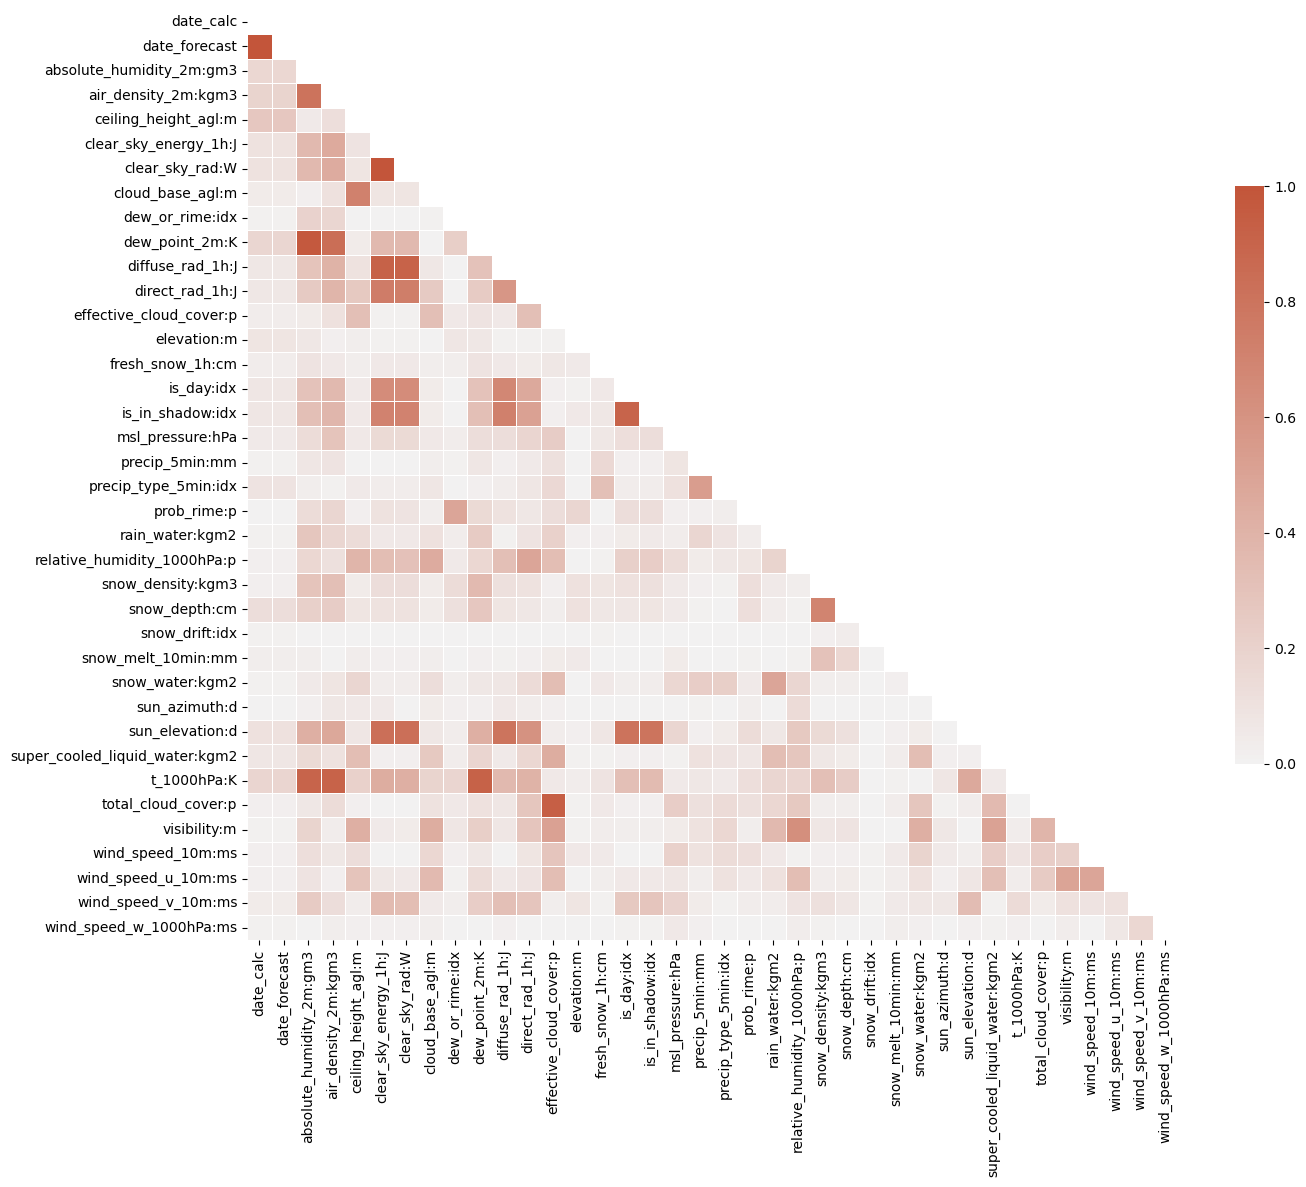

In [96]:
show_corr_matrix(X)

## Air attributes

Now I want to take a look at the correlation between 't_1000hPa:K', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K'

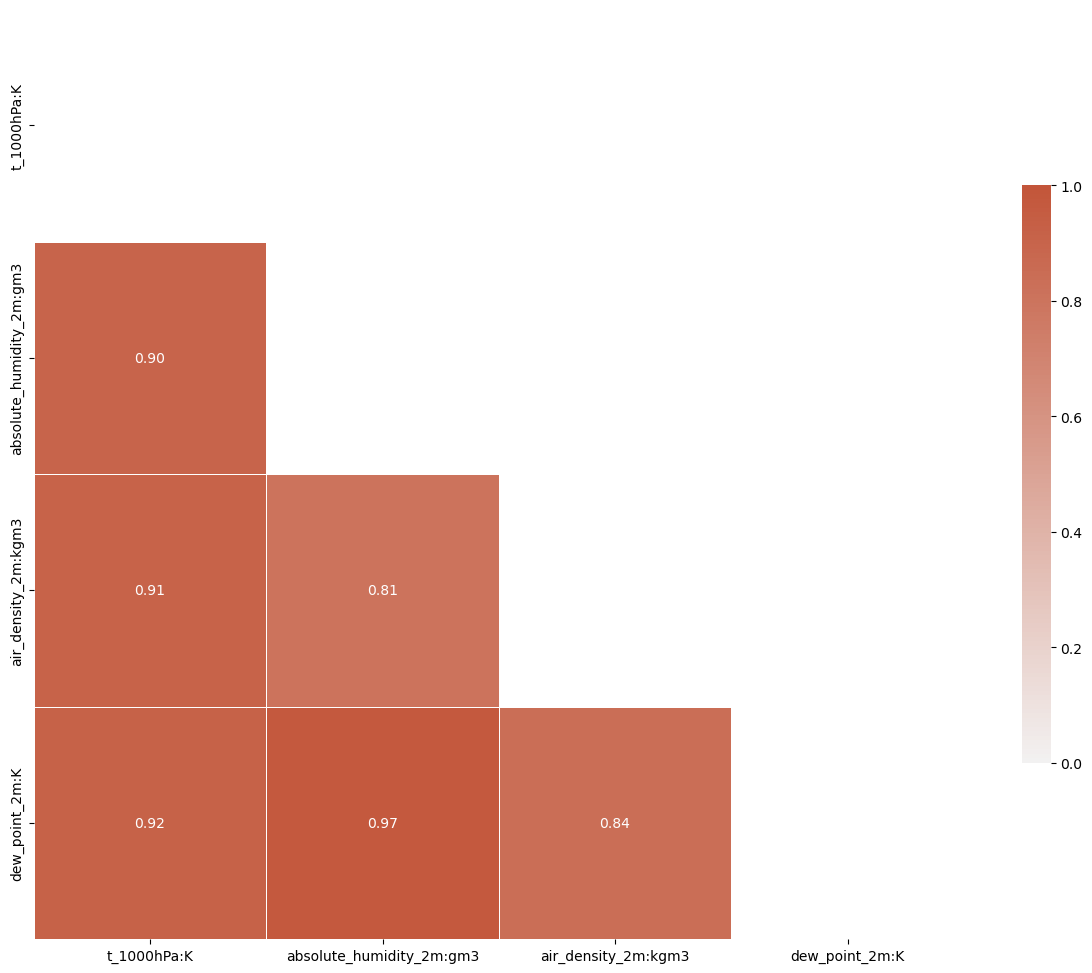

In [97]:
air_attributes = ['t_1000hPa:K', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K']

show_corr_matrix_with_values(X[air_attributes])


Let's look into what the features tell us:

**t_1000hPa:K**: Instantaneous temperature at the indicated level above ground in the corresponding unit [K]

**absolute_humidity_2m:gm3**: Absolute humidity at 2m in . Note: the absolute humidity is only available at 2m.

**air_density_2m:kgm3**: Density of air at any height level above ground up to 10 km.

**dew_point_2m:K**: Instantaneous value of the dew point temperature at the indicated level.

I choose to keep the **t_1000hPa:K** feature as this has the highest overall correlation to all the other features.

In [98]:
to_drop = ['absolute_humidity_2m:gm3','air_density_2m:kgm3','dew_point_2m:K']

X.drop(to_drop, axis=1, inplace=True)

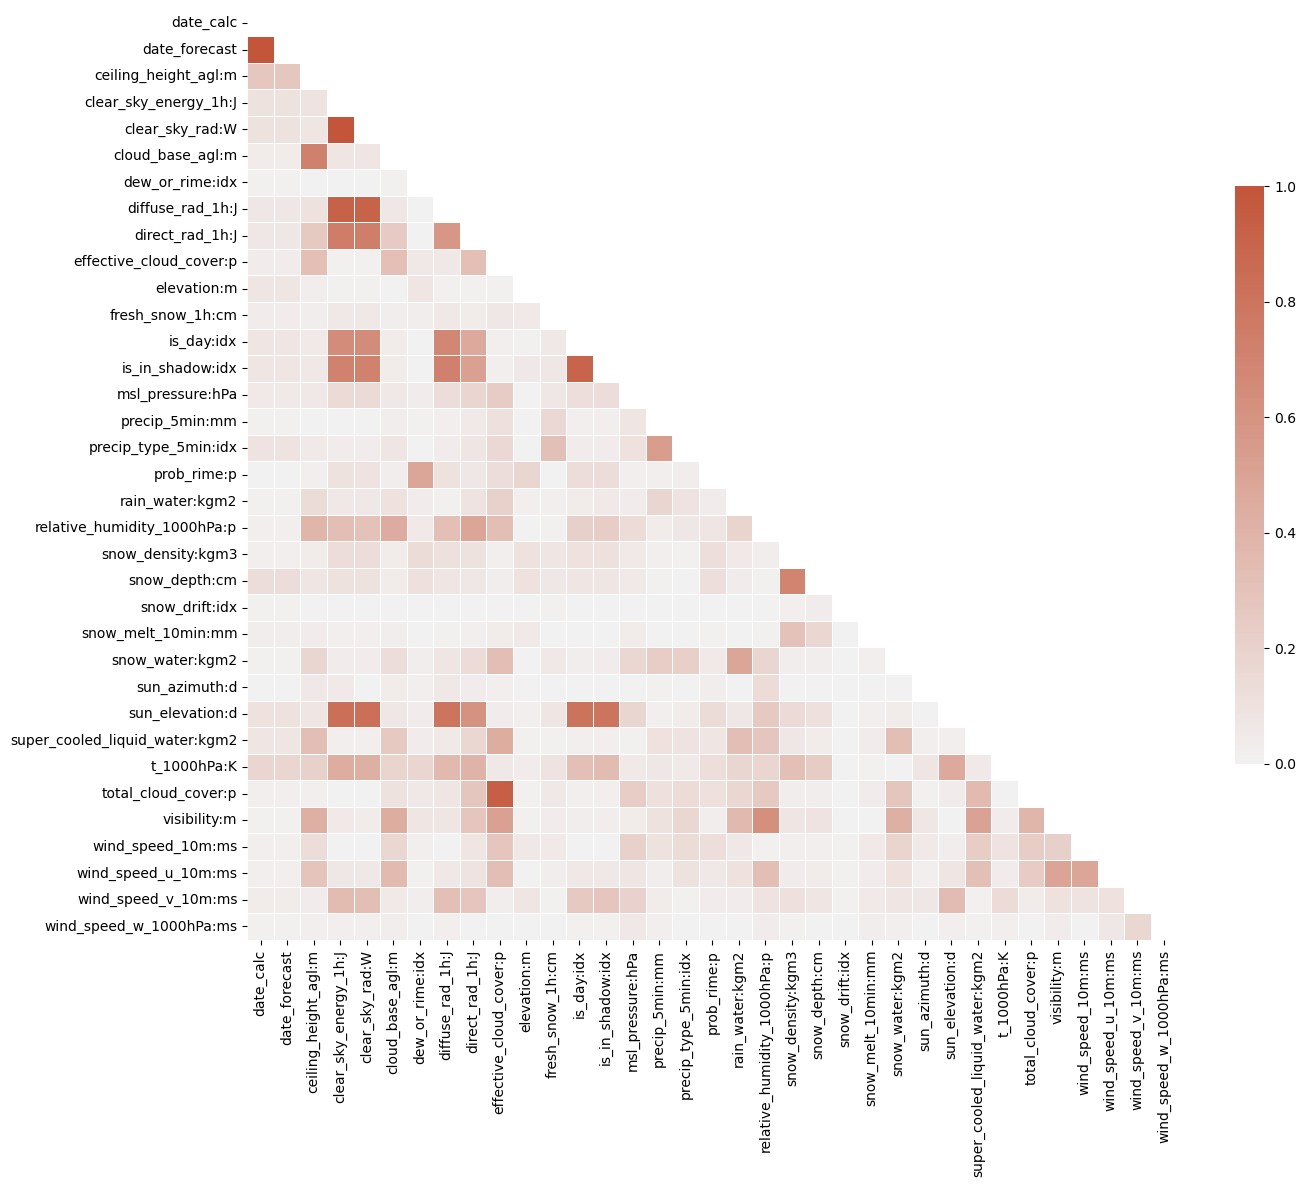

In [99]:
show_corr_matrix(X)

## Clear sky energy and clear sky rad

**clear_sky_rad:W**: Instantaneous flux of clear sky radiation in Watts per square meter

**clear_sky_energy_1h:J**: clear sky energy of previous time period, available up to 24h [J/m2]

This is what chatGPT says about clear sky energy:

*"Clear sky energy" refers to the amount of solar energy that reaches the Earth's surface from the sun when the sky is clear of clouds and other atmospheric obstructions. It represents the maximum potential solar energy available at a specific location under ideal conditions, assuming there are no atmospheric factors, such as clouds or pollution, that would attenuate or scatter the sunlight.*

*Clear sky energy is often used in solar energy and photovoltaic (PV) system analysis and design. Solar energy professionals use clear sky models to estimate the amount of energy that can be harvested from solar panels under optimal conditions, taking into account factors like the position of the sun, the latitude of the location, and the time of day.*

*It's important to note that in real-world applications, the actual solar energy output from a solar panel or system can be significantly lower than the clear sky energy due to various factors, including cloud cover, air pollution, shading, and the efficiency of the solar panels. Clear sky energy serves as a reference point and helps in understanding the maximum solar energy potential at a given location.*

The same goes for the radiation:

*"Clear sky radiation" refers to the amount of solar radiation that reaches the Earth's surface from the sun when there are no clouds or other atmospheric obstructions present. It represents the maximum potential solar radiation that can be received at a specific location under ideal conditions, assuming a perfectly clear and cloudless sky.*

*Clear sky radiation is an important concept in the field of meteorology, solar energy, and climate science. It is often used to estimate the amount of solar energy available at a particular location and time. Clear sky radiation models take into account factors like the solar zenith angle, the latitude of the location, and the time of day to calculate the expected solar radiation under clear sky conditions.*

*Just like clear sky energy, clear sky radiation provides a baseline reference for the maximum solar radiation that can be received at a given location. In practical applications, the actual solar radiation received may be lower than the clear sky radiation due to the presence of clouds, atmospheric particles, and other weather-related factors. Clear sky radiation is a useful concept for understanding the solar energy potential in a specific area and can be valuable for solar energy system design and forecasting.*

Let's check the correlation between the 2:

In [100]:
correlation = X["clear_sky_rad:W"].corr(X["clear_sky_energy_1h:J"])

print(correlation)

0.9923753501744561


As the correlation is almost a perfect 1 I'll remove one of them. As the "clear sky energy" is a cumulative 1h value I'll choose that.

In [101]:
X.drop("clear_sky_rad:W", axis=1, inplace=True)

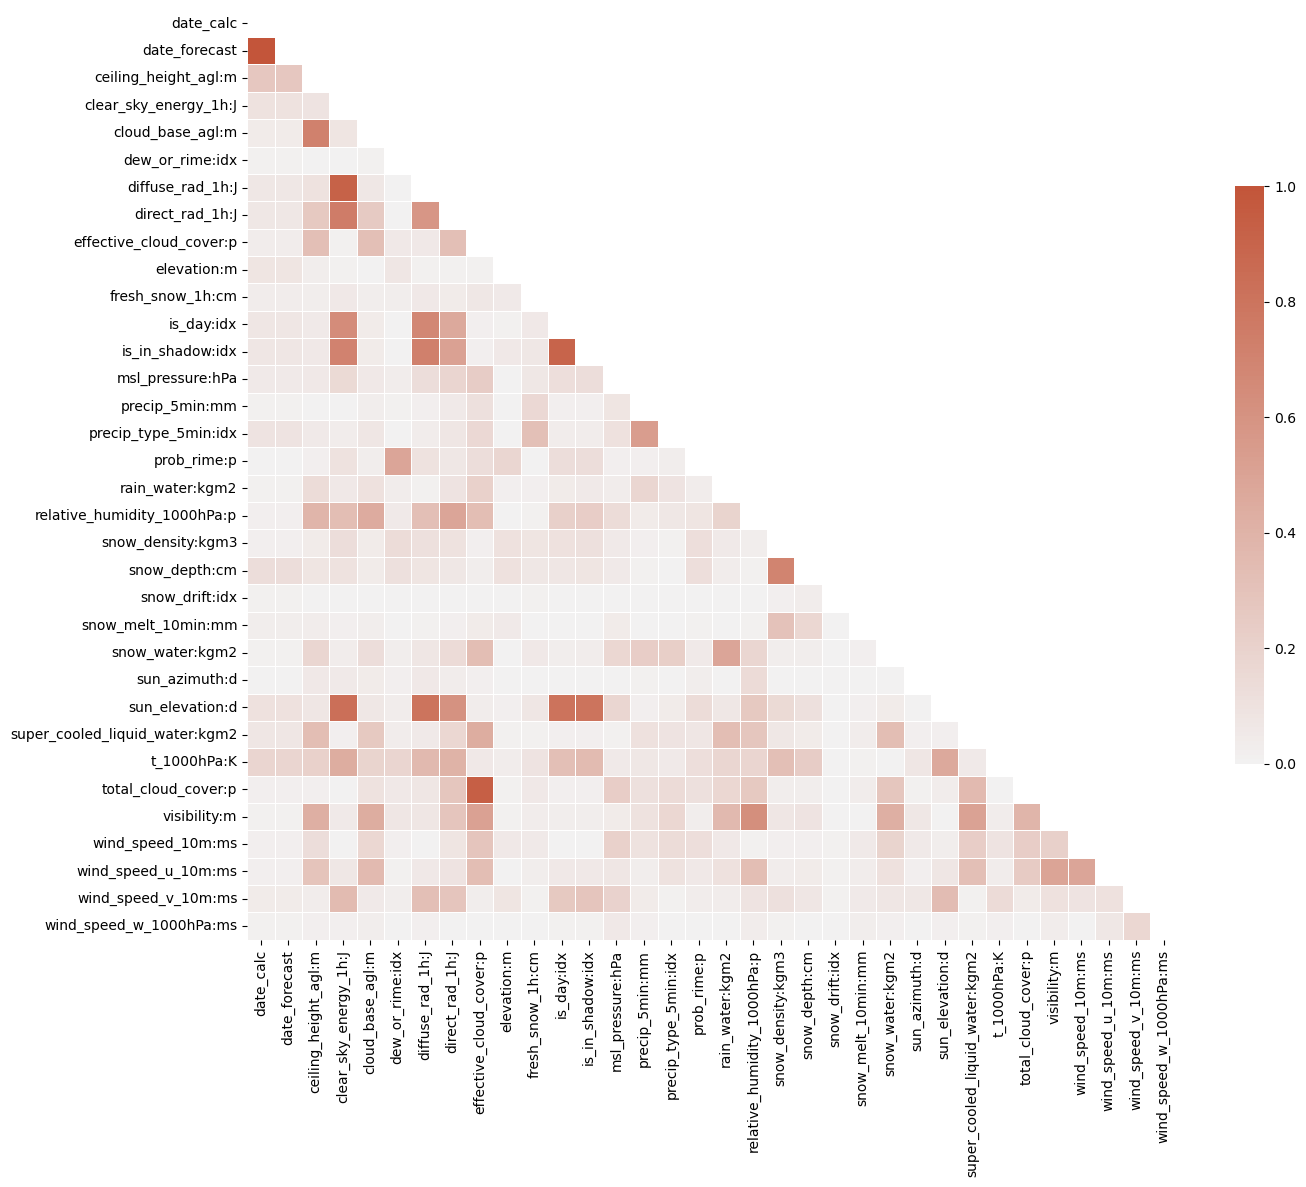

In [102]:
show_corr_matrix(X)

## Sun elevation

Let's take a look at the correlations of **sun_elevation:d**

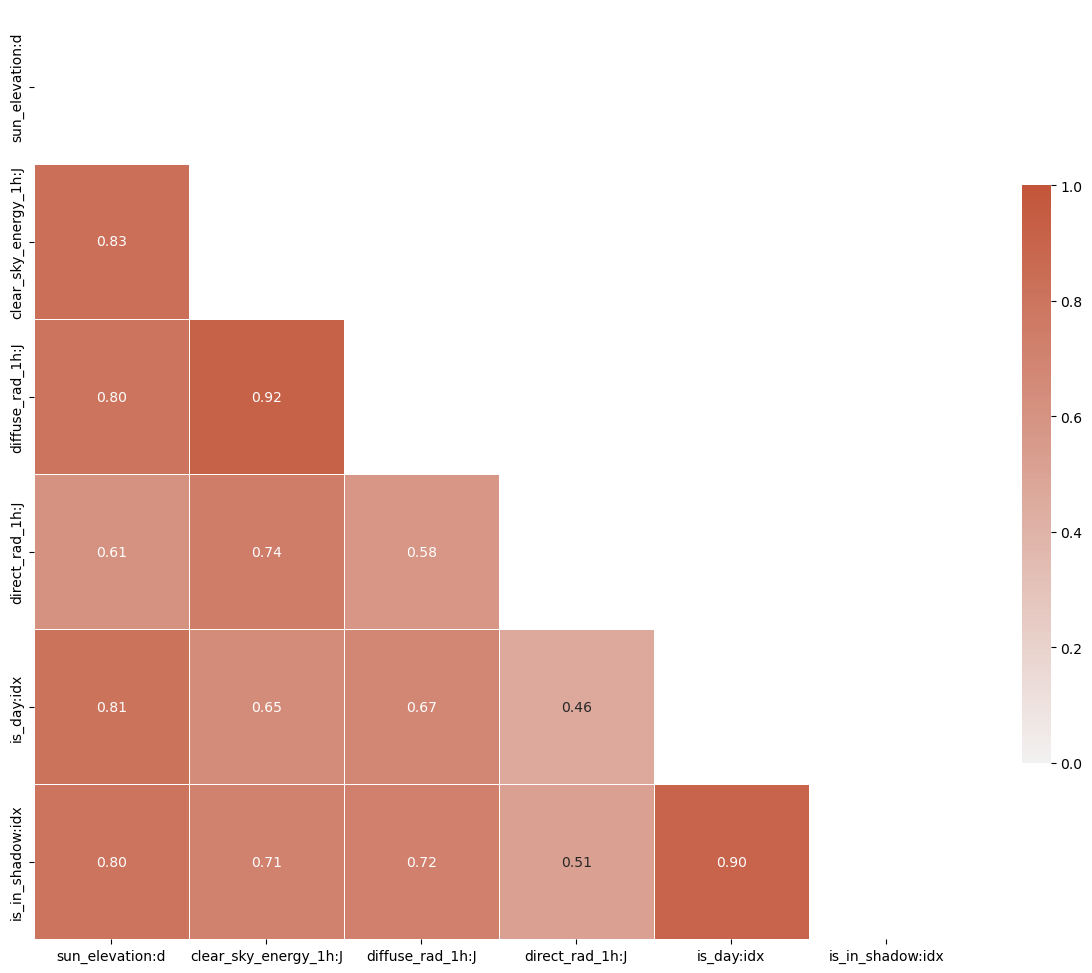

In [103]:
sun_elevation_correlations = ['sun_elevation:d', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx']

show_corr_matrix_with_values(X[sun_elevation_correlations])

As **sun_elevation:d** has a lot of correlations over the normal treshold 0.75 I'll remove it.

**diffuse_rad_1h:J** has a strong correlation to **clear_sky_energy_1h:J**.

**diffuse_rad_1h:J**: accumulated diffuse radiation of previous time period, available up to 24h [J/m2]

*Diffuse radiation, in the context of solar energy and meteorology, refers to the solar radiation that arrives at the Earth's surface after being scattered in various directions by the Earth's atmosphere. Unlike direct solar radiation, which comes in a straight line from the sun to a specific point on the Earth's surface, diffuse radiation is scattered in multiple directions due to interactions with atmospheric particles, gases, and molecules.*

As this seems like a better measurement than clear sky energy that is only theortical, I'm going to remove the energy one.

Lastly we have a strong correlation between **is_in_shadow:idx** and **is_day:idx**.

**is_in_shadow:idx**: returns 1 or 0 depending on whether the coordinate is in shadow of the topography at the specified time or not.

As this says something about the shadow with regard to the topography and not clouds I think is_day is more relevant to us, so I'll choose that one.

In [104]:
to_drop = ['sun_elevation:d', 'clear_sky_energy_1h:J', 'is_in_shadow:idx']

X.drop(to_drop, axis=1, inplace=True)

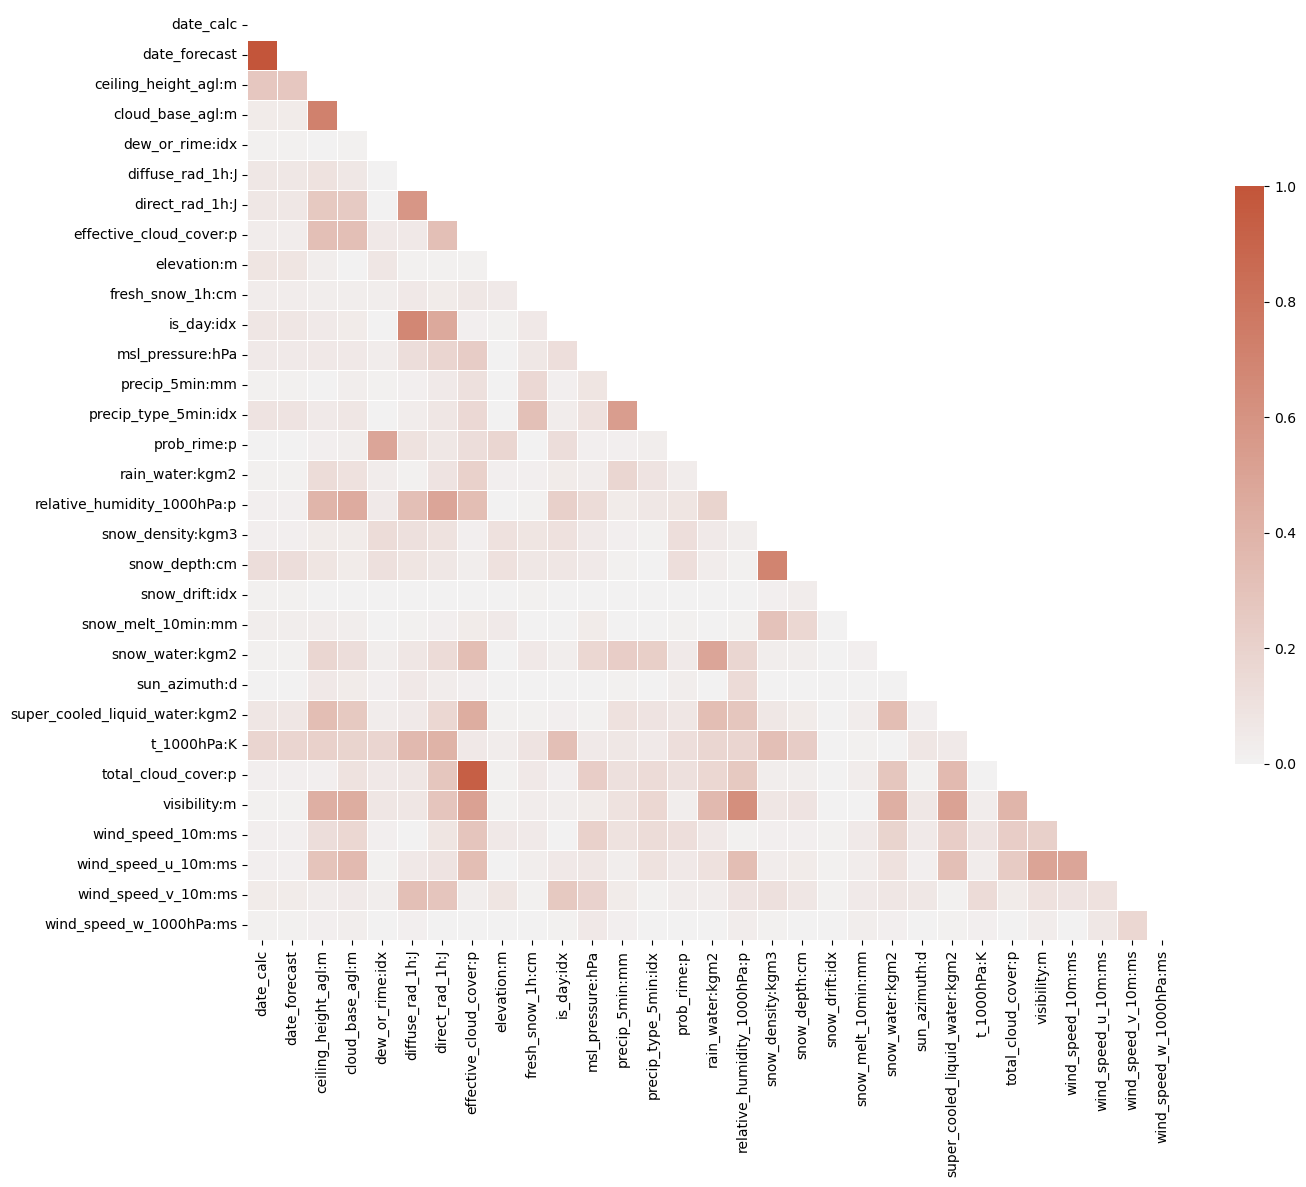

In [105]:
show_corr_matrix(X)

## Cloud cover

The final correlation to be investigated is related to cloud cover.

**total_cloud_cover:p**: cloud cover is the fraction of the sky covered by cloud at any height. Due to overlapping clouds at different heights, it may not correspond to the sum of the low, medium and high cloud covers.

**effective_cloud_cover:P**: cloud cover is a weighted sum of the low, medium and high level cloud covers relevant for solar energy forecasts. The low and medium level clouds have a higher weight than the high level clouds as the low and medium level clouds block more radiation.

As stated, the effective cloud cover is relevant for solar energy forecasts, thus we'll remove the other one

In [106]:
X.drop("total_cloud_cover:p", axis=1, inplace=True)

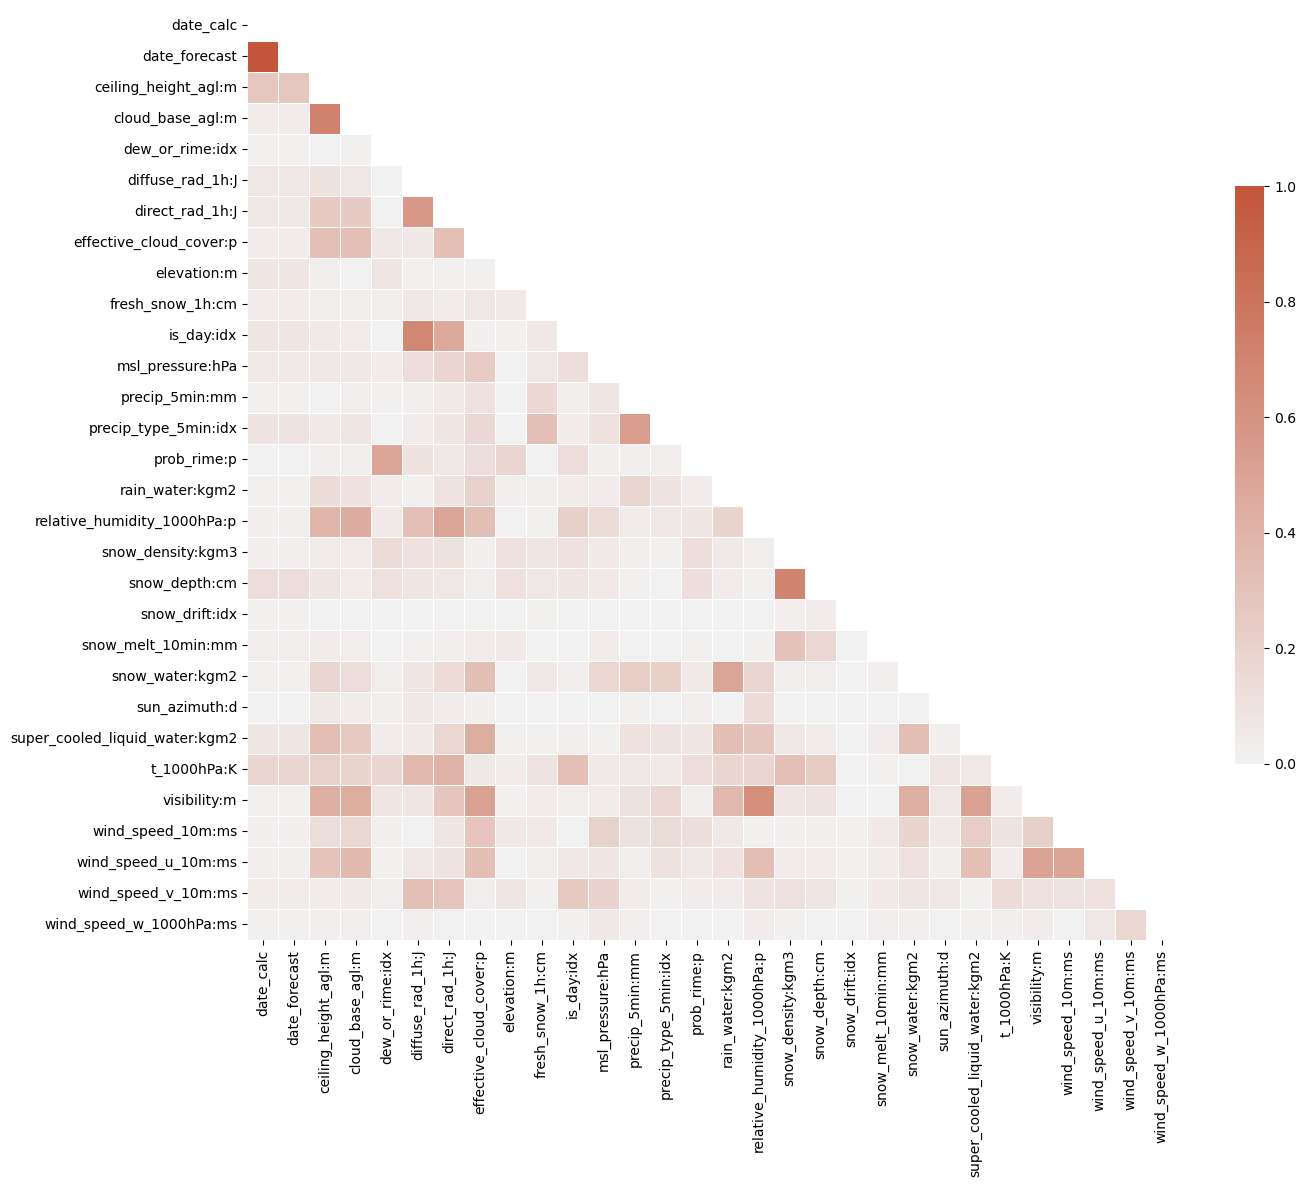

In [107]:
show_corr_matrix(X)

## TL;DR

In [ ]:
to_drop = ['fresh_snow_12h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'diffuse_rad:W', 'direct_rad:W', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa', 'absolute_humidity_2m:gm3','air_density_2m:kgm3','dew_point_2m:K', 'clear_sky_rad:W', 'sun_elevation:d', 'clear_sky_energy_1h:J', 'is_in_shadow:idx', 'total_cloud_cover:p']